In [5]:
import pandas as pd

In [4]:
import numpy as np

## Simple data preprocessing

In [39]:

# From https://github.com/kulraghav/MLPractice/blob/master/Notebooks/spam_filter.ipynb
# when encoding is unknown
import chardet 
with open("spam.tsv", 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

print(result['encoding'])
df_raw = pd.read_csv('spam.tsv', encoding=result['encoding'], delimiter='\t')



utf-8


In [40]:
df_raw.head()

,isSpam,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [41]:
df_raw.describe()

,isSpam,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [42]:
df_raw.drop_duplicates(subset="SMS", inplace=True)

In [10]:
from sklearn.model_selection import train_test_split

In [43]:

X = df_raw['SMS']
y = df_raw['isSpam']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


## Create corpus and Vectorizer

In [44]:

print("Shape of X is {}".format(X.shape))
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

train_corpus = list(X_train)

Shape of X is (5169,)
Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (1293,) and shape of y_test is (1293,)


In [46]:
"""
    Featurizer: Train the featurizer on train data.
"""
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_corpus)

print("Number of features = {}".format(len(vectorizer.vocabulary_)))
print("Number of omitted words = {}".format(len(vectorizer.stop_words_)))

X_train_text_features = vectorizer.transform(list(X_train))
X_test_text_features  = vectorizer.transform(list(X_test))

print("Shape of X_train_text_features is {}".format(X_train_text_features.shape))
print("Shape of X_test_text_features is {}".format(X_test_text_features.shape))

Number of features = 5000
Number of omitted words = 2419
Shape of X_train_text_features is (3876, 5000)
Shape of X_test_text_features is (1293, 5000)



## K nearest neighbours

KNN classifers are the most simple classifiers. For each data point to classify we consider the k nearest neighbours of the training data and choose the majority class among them

## Logisitic Regression

Logistic regression works exactly like linear regression but we apply the logit (sigmoid $f(x) = \frac{1}{1 + e^{-x}}$) function on the output from the linear regression to get a probability of each class

## Random Forests

Random forests contain multiple decision trees. Each decision tree is trained on a subset of the features and then a weighted sum of their predicted is used for the final prediction.

Logistic Regression
The fraction of correctly classified samples is 0.9597834493426141
The number of correctly classified samples is 1241
F1 score = 0.8300653594771242
           pred ham  pred spam
true ham       1114         49
true spam         3        127



/home/bhishma/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


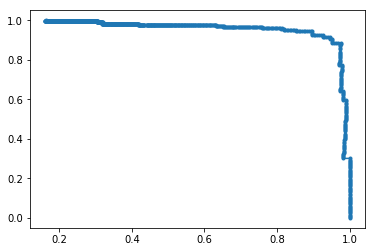

Logistic Regression cv scores [0.94974227 0.95360825 0.95741935 0.96387097 0.95219638]
Random Forests
The fraction of correctly classified samples is 0.97138437741686
The number of correctly classified samples is 1256
F1 score = 0.8832807570977916
           pred ham  pred spam
true ham       1116         36
true spam         1        140



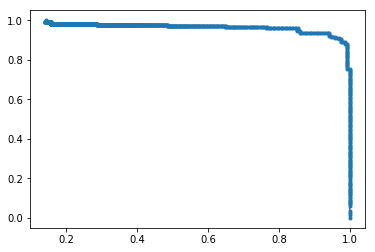

Random Forests cv scores [0.97164948 0.97036082 0.96774194 0.98064516 0.97028424]
K nearest neighbours
The fraction of correctly classified samples is 0.9590100541376644
The number of correctly classified samples is 1240
F1 score = 0.822742474916388
           pred ham  pred spam
true ham       1117         53
true spam         0        123



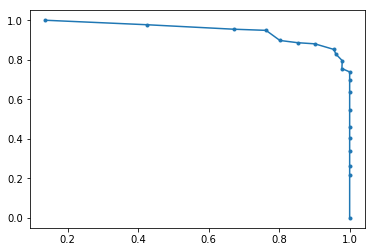

K nearest neighbours cv scores [0.94458763 0.96005155 0.95483871 0.96       0.95865633]


In [66]:
"""
    Evaluation within training data: k-fold cross validation
        - randomly partition the training data into k parts
        - train on k-1 parts and evaluate on the remaining part
"""

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=0)
knn_model = neighbors.KNeighborsClassifier(n_neighbors=25)

models = [('Logistic Regression', lr_model),
          ('Random Forests', rf_model),
          ('K nearest neighbours', knn_model)]

for name, model in models:    
    print(name)
    print("====================")
    
    model.fit(X_train_text_features, y_train)
    y_test_predicted = model.predict(X_test_text_features)
    probs = [p[1] for p in model.predict_proba(X_test_text_features)]

    print("The fraction of correctly classified samples is {}".format(accuracy_score(y_test, y_test_predicted)))
    print("The number of correctly classified samples is {}".format(accuracy_score(y_test, 
                                                                                   y_test_predicted, normalize=False)))

    print("F1 score = {}".format(f1_score(y_test, y_test_predicted,pos_label='spam')))

    print(pd.DataFrame(confusion_matrix(y_test_predicted, y_test), 
                 index={'true ham', 'true spam'}, 
                 columns={'pred ham', 'pred spam'}))

    print()
    
    precision, recall, _ = precision_recall_curve(y_test, probs, pos_label='spam')
    plt.plot(precision, recall, marker='.')
    plt.show()
    
    print("{} cv scores {}".format(name, cross_val_score(model, X=X_train_text_features, y=y_train, cv=5, n_jobs=4)))
    
    print("====================")

